# Chapter 7 MCMC under the Hood

## 7.1 The big idea

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import requests
import seaborn as sns

from plotnine import (
    aes,
    after_stat,
    geom_histogram,
    geom_line,
    ggplot,
    labs,
    stat_function,
)
from scipy.stats import beta, binom, norm, uniform

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%load_ext nb_black
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

/Users/tomkealy/opt/anaconda3/envs/bayes_rules/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


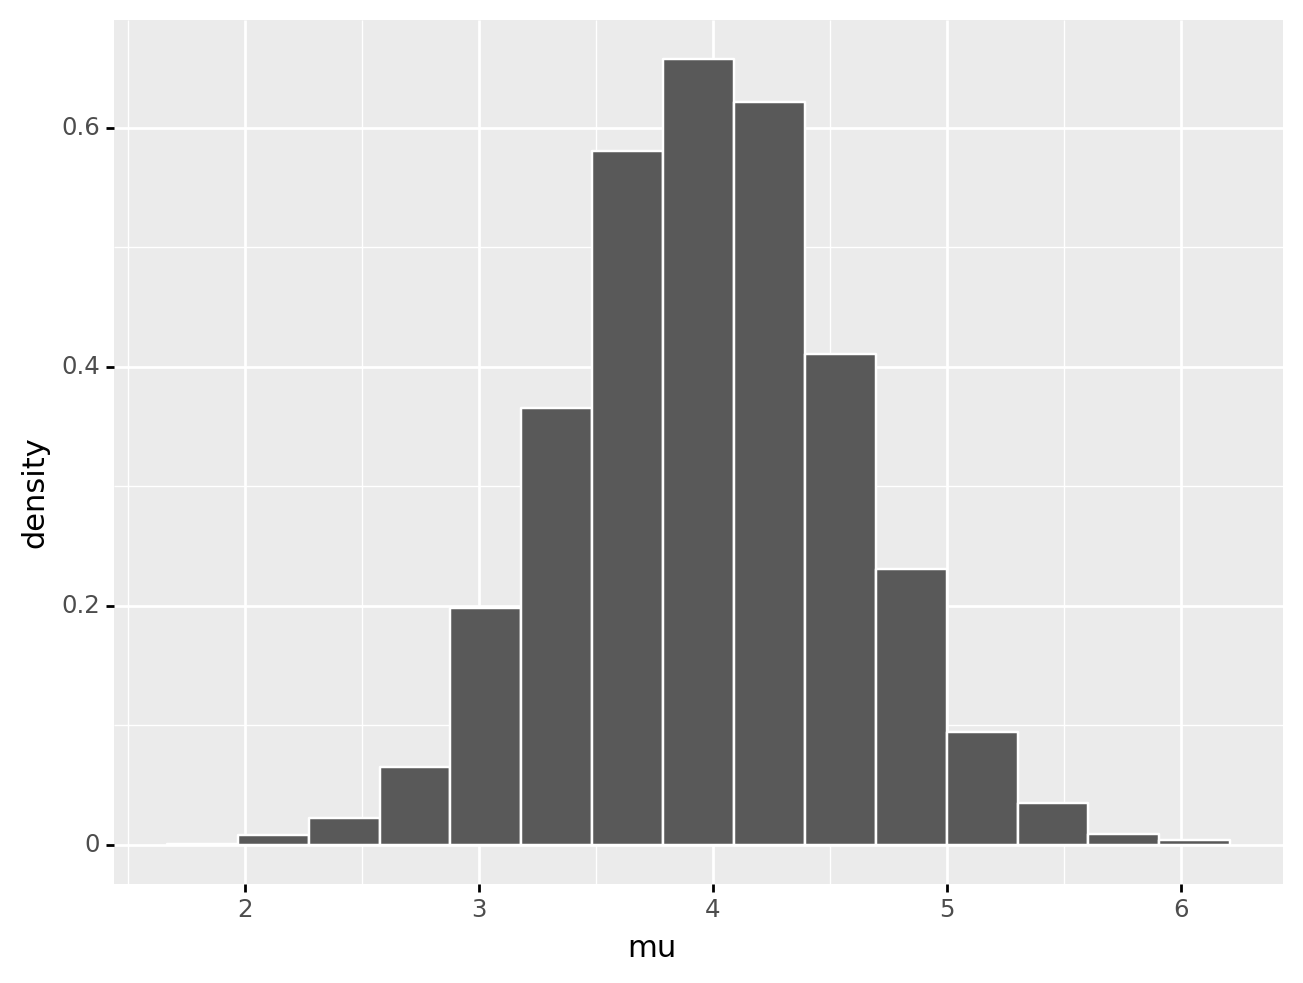

<ggplot: (388540924)>

<IPython.core.display.Javascript object>

In [3]:
mc_tour = pd.DataFrame(data={"mu": np.random.normal(4, 0.6, 5000)})

(
    ggplot(mc_tour, aes(x=mc_tour["mu"]))
    + geom_histogram(aes(y=after_stat("density")), color="white", bins=15)
    + stat_function(fun=norm.ppf, args=4, color="blue")
)

## 7.2 The Metropolis-Hastings algorithm

In [4]:
current = 3
proposal = rng.uniform(low=current - 1, high=current + 1)
proposal

2.060225707987863

<IPython.core.display.Javascript object>

In [5]:
proposal_plaus = norm.pdf(proposal, 0, 1) * norm.pdf(6.25, proposal, 0.75)
proposal_plaus

4.250620045181512e-09

<IPython.core.display.Javascript object>

In [6]:
current_plaus = norm.pdf(current, 0, 1) * norm.pdf(6.25, current, 0.75)
current_plaus

1.9719280468414924e-07

<IPython.core.display.Javascript object>

In [7]:
alpha = min(1, proposal_plaus / current_plaus)
alpha

0.021555654893138123

<IPython.core.display.Javascript object>

In [8]:
np.random.choice([proposal, current], size=1, replace=True, p=[alpha, 1 - alpha])

array([3.])

<IPython.core.display.Javascript object>

In [9]:
def one_mh_iteration(w, current):
    proposal = rng.uniform(low=current - w, high=current + w)
    proposal_plaus = norm.pdf(proposal, 0, 1) * norm.pdf(6.25, proposal, 0.75)
    current_plaus = norm.pdf(current, 0, 1) * norm.pdf(6.25, current, 0.75)
    alpha = min(1, proposal_plaus / current_plaus)
    next_stop = np.random.choice([proposal, current], size=1, replace=True, p=[alpha, 1 - alpha])
    data = {"proposal": proposal, "alpha": alpha, "next_stop": next_stop}
    return pd.DataFrame(data)

<IPython.core.display.Javascript object>

In [10]:
one_mh_iteration(w=1, current=3)

,proposal,alpha,next_stop
0,3.707278,1,3.707278


<IPython.core.display.Javascript object>

## 7.3 Implementing the Metropolis-Hastings

In [11]:
def mh_tour(N, w):
    current = 3
    mu = np.zeros(N)
    for step in range(N):
        sim = one_mh_iteration(w=w, current=current)
        mu[step] = sim["next_stop"]
        current = sim["next_stop"][0]
    return pd.DataFrame(mu, columns=["mu"])

<IPython.core.display.Javascript object>

In [12]:
mh_tour(N=5, w=1)

,mu
0,3.000000
1,3.000000
2,3.000000
3,3.787656
4,4.463304


<IPython.core.display.Javascript object>

In [13]:
mh_simulation = mh_tour(N=5000, w=1)

<IPython.core.display.Javascript object>

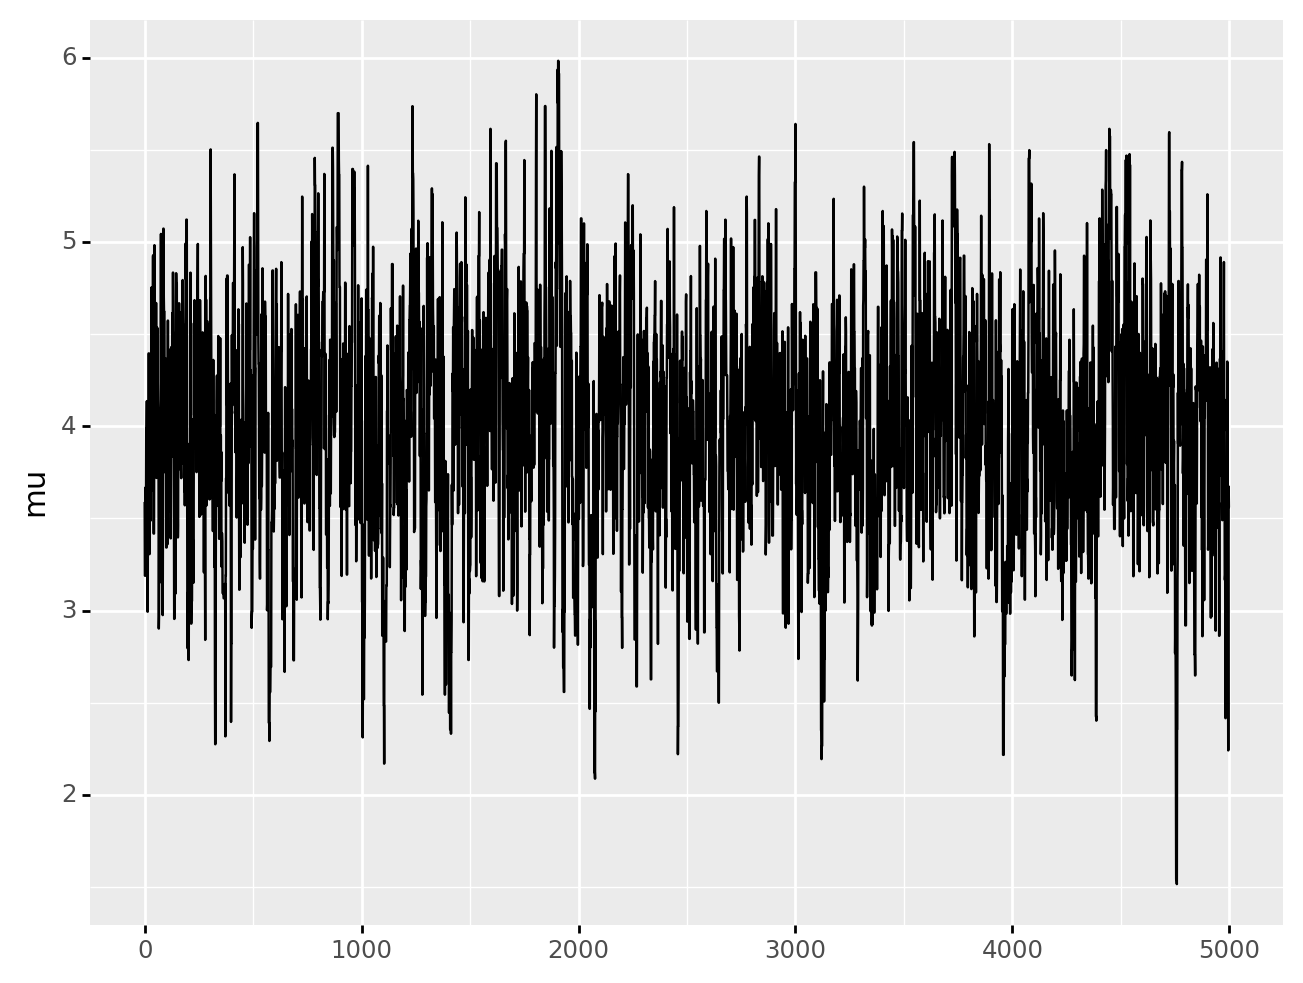

<ggplot: (291009041)>

<IPython.core.display.Javascript object>

In [14]:
ggplot(mh_simulation, aes(x=mh_simulation.index, y=mh_simulation["mu"])) + geom_line()

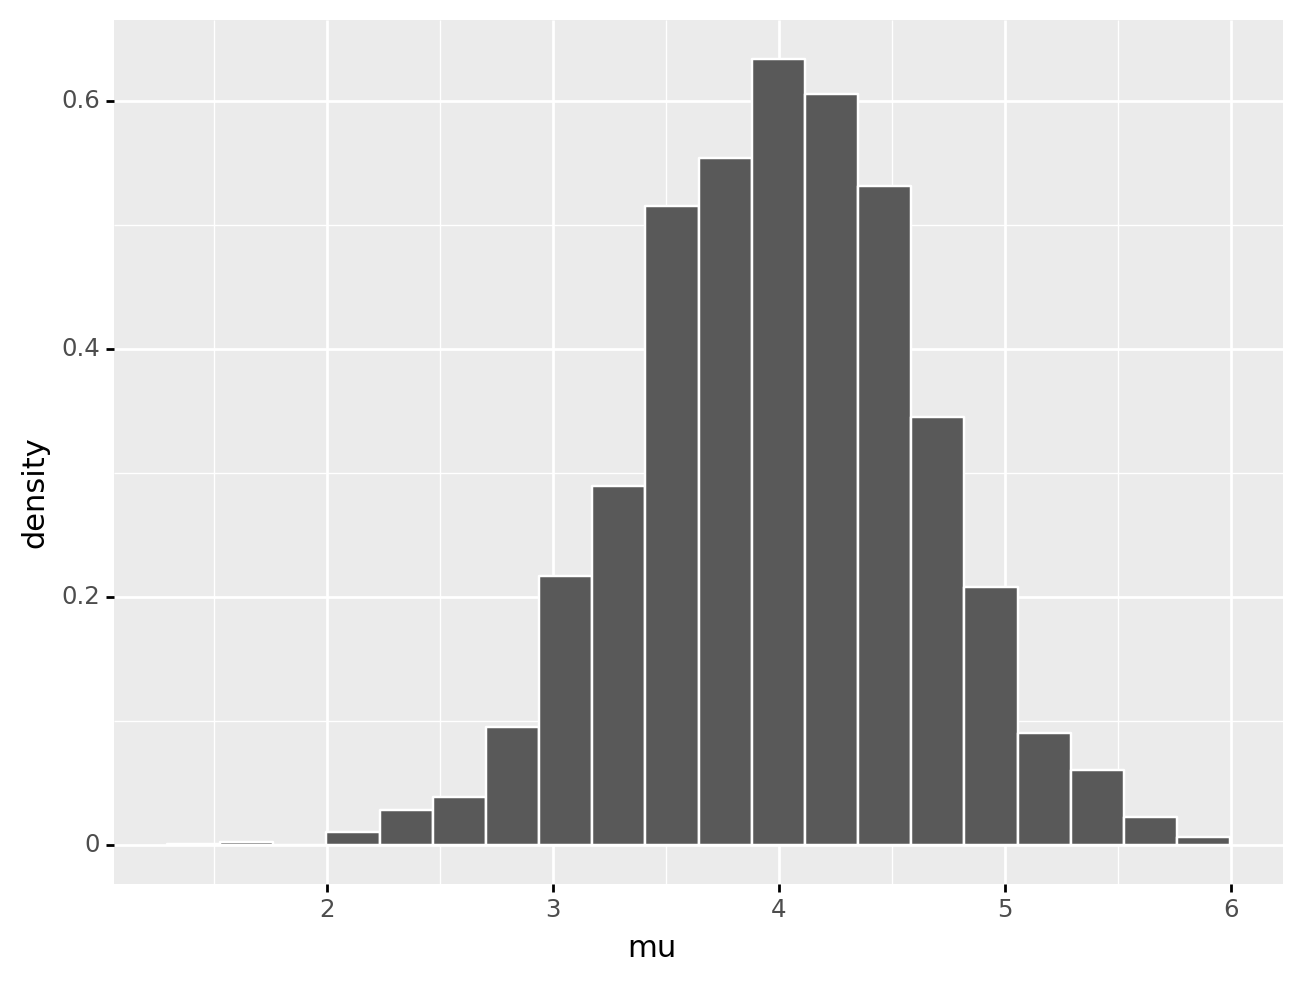

<ggplot: (290983873)>

<IPython.core.display.Javascript object>

In [15]:
ggplot(mh_simulation, aes(x=mh_simulation["mu"])) + geom_histogram(
    aes(y=after_stat("density")), color="white", bins=20
)  # + stat_function(fun = norm.pdf, args = np.array([4,0.6]), color = "blue")

## 7.4 Tuning the Metropolis-Hastings algorithm

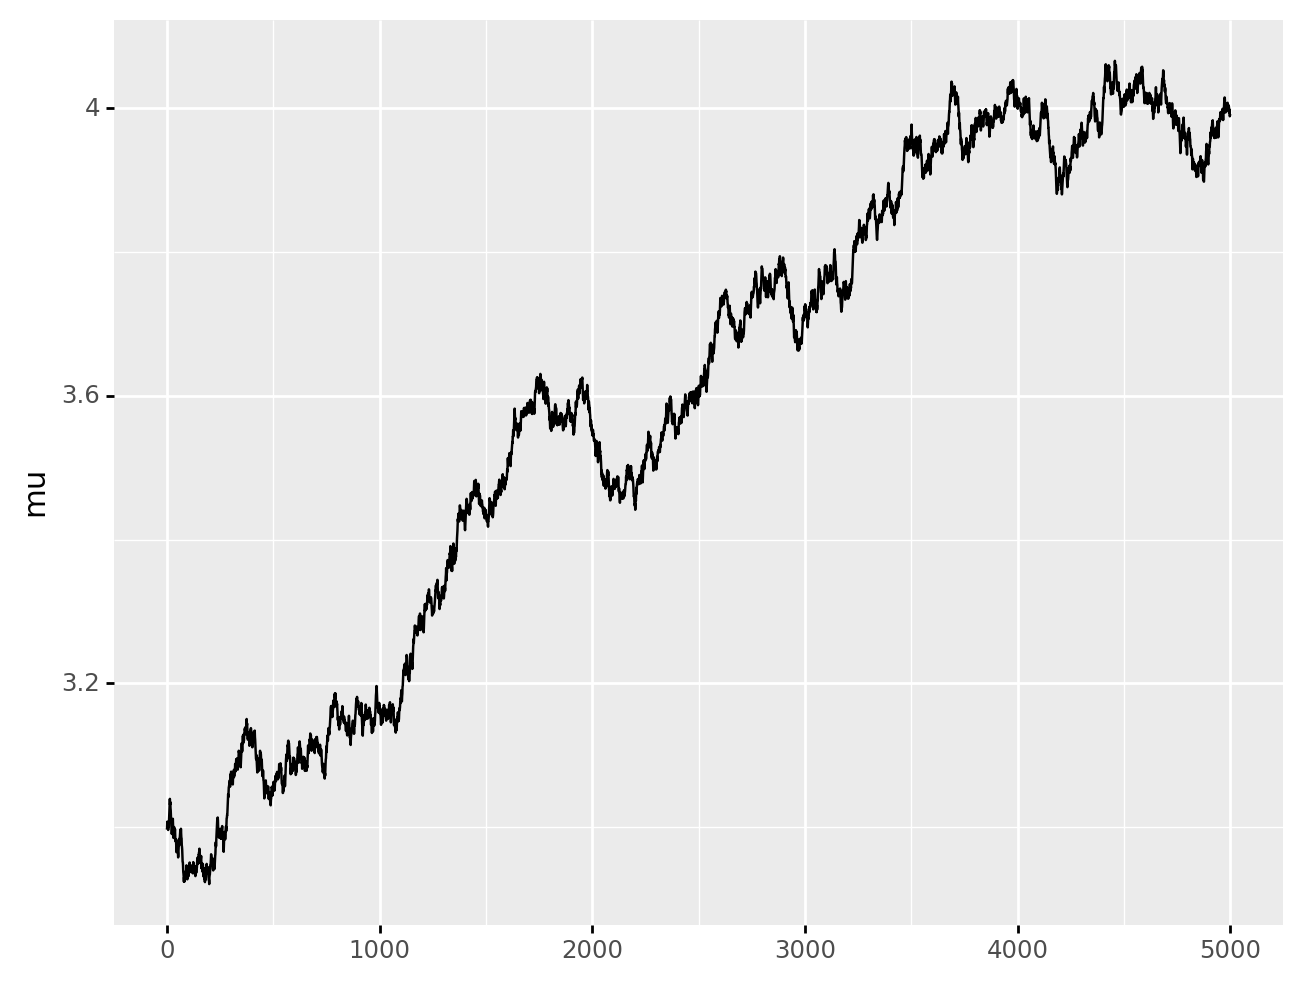

<ggplot: (389291945)>

<IPython.core.display.Javascript object>

In [16]:
mh_simulation = mh_tour(N=5000, w=0.01)
ggplot(mh_simulation, aes(x=mh_simulation.index, y=mh_simulation["mu"])) + geom_line()

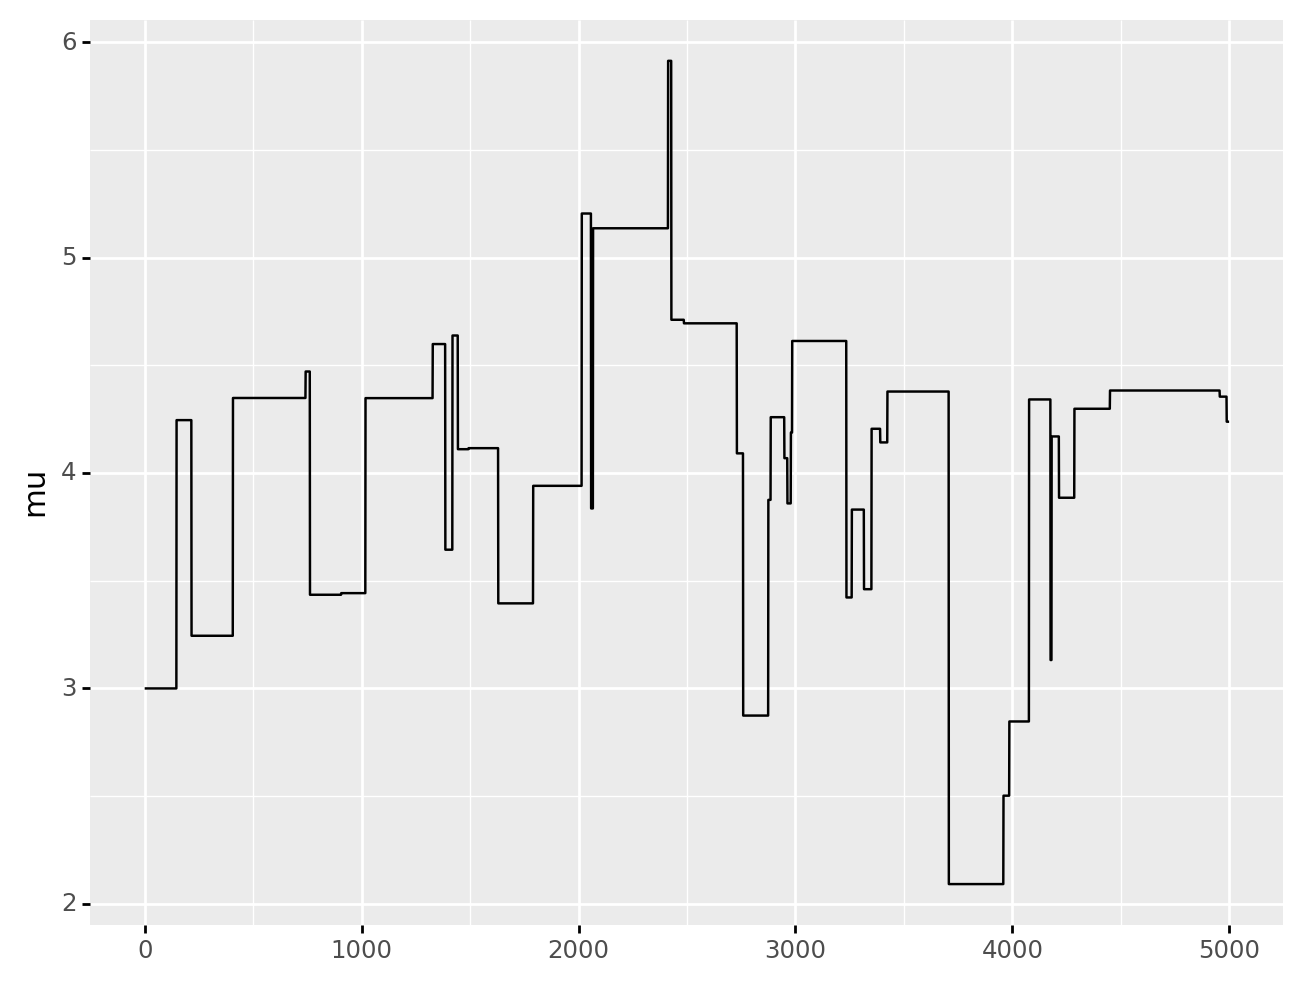

<ggplot: (389330047)>

<IPython.core.display.Javascript object>

In [17]:
mh_simulation = mh_tour(N=5000, w=100)
ggplot(mh_simulation, aes(x=mh_simulation.index, y=mh_simulation["mu"])) + geom_line()

## 7.5 A Beta-Binomial example

In [28]:
def one_beta_binom_iteration(a, b, current):
    proposal = rng.beta(a, b)
    proposal_plaus = beta.pdf(proposal, 2, 3) * binom.pmf(1, 2, proposal)
    proposal_q = beta.pdf(proposal, a, b)
    current_plaus = beta.pdf(current, 2, 3) * binom.pmf(1, 2, current)
    current_q = beta.pdf(current, a, b)
    alpha = min(1, proposal_plaus / current_plaus * current_q / proposal_q)
    next_stop = np.random.choice([proposal, current], size=1, replace=True, p=[alpha, 1 - alpha])
    data = {"proposal": proposal, "alpha": alpha, "next_stop": next_stop}
    return pd.DataFrame(data)

<IPython.core.display.Javascript object>

In [29]:
def beta_binom_tour(N, a, b):
    current = 0.5
    mu = np.zeros(N)
    for step in range(N):
        sim = one_beta_binom_iteration(a=a, b=b, current=current)
        mu[step] = sim["next_stop"]
        current = sim["next_stop"][0]
    return pd.DataFrame(mu, columns=["mu"])

<IPython.core.display.Javascript object>

In [30]:
betabin_sim = beta_binom_tour(N=5000, a=1, b=1)

<IPython.core.display.Javascript object>